<a href="https://colab.research.google.com/github/egorgladin/gan-optimization/blob/develop/1d_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

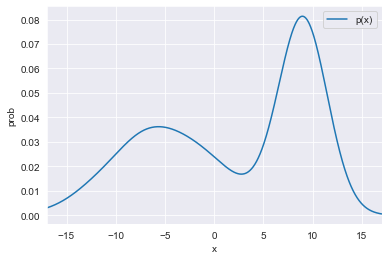

In [12]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import torch
from torch.optim.optimizer import Optimizer, required
from quickprop_sgd import QuickPropSGD
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
from IPython.display import display, clear_output
import time
sns.set_style('darkgrid')

SHIFT = 0
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def sample_real_data(size):
    x1 = torch.randn(size, 1) * 1.5 + 9 + SHIFT
    x2 = torch.randn(size, 1) * 5.0 - 5 + SHIFT
    u = torch.rand(size, 1)
    return np.where(u > 0.5, x1, x2)

def plot_data(x, ax=plt):
    kde = KernelDensity(bandwidth=2.0, kernel='gaussian')
    kde.fit(x)
    x_grid = np.linspace(-17 + SHIFT, 17 + SHIFT, 1000)[:, None]
    logprob = kde.score_samples(x_grid)
    ax.set_xlim([-17 + SHIFT, 17 + SHIFT])
    ax.plot(x_grid, np.exp(logprob))
    return kde

def plot_classifier(cls, kde_real, kde_fake, ax=plt):
    x_grid = np.linspace(-17 + SHIFT, 17 + SHIFT, 1000)[:, None]
    p_pred = torch.sigmoid(cls(torch.from_numpy(x_grid).float().to(DEVICE))).cpu()
    p_real = np.exp(kde_real.score_samples(x_grid))
    p_fake = np.exp(kde_fake.score_samples(x_grid))
    p_bayes = p_real / (p_real + p_fake + 1e-7)
    ax.set_xlim([-17 + SHIFT, 17 + SHIFT])
    ax.plot(x_grid, p_pred.detach().cpu(), 'r--')
    ax.plot(x_grid, p_bayes, 'r')
    

X_real = sample_real_data(10000)
ax = plt.subplot()
plot_data(X_real, ax)
plt.legend(['p(x)'])
plt.xlabel('x')
plt.ylabel('prob')
plt.show()

In [39]:
def calc_loss(real_preds=None, fake_preds=None, net_name=''):
    if net_name == 'dis':
        loss_real = -torch.log(real_preds)
        loss_fake = -torch.log(1 - fake_preds)
        loss = (loss_real + loss_fake) * 0.5
    elif net_name == 'gen':
        loss = -torch.log(fake_preds)
    return loss.mean()

def train_dis(dis, gen, dis_opt, gen_opt, batch_size, loss = calc_loss):
    # Forward real
    x_real = torch.from_numpy(sample_real_data(batch_size)).float().to(DEVICE)
    real_preds = dis(x_real)
    
    # Forward fake
    z = torch.randn(batch_size, 1).to(DEVICE)
    x_fake = gen(z)
    fake_preds = dis(x_fake.detach())

    # Discriminator lossesM
    loss_D = loss(real_preds, fake_preds, net_name='dis')

    # Discriminator step
    dis_opt.zero_grad()
    loss_D.backward()
    dis_opt.step()

    return loss_D.item()

def train_gen(dis, gen, dis_opt, gen_opt, batch_size, loss = calc_loss, ):
    # Forward fake
    z = torch.randn(batch_size, 1).to(DEVICE)
    x_fake = gen(z)
    fake_preds = dis(x_fake)

    # Generator losses
    loss_G = loss(None, fake_preds, net_name='gen')

    # Generator step
    gen_opt.zero_grad()
    loss_G.backward()
    gen_opt.step()

    return loss_G.item()

# Generator is an MLP that converts noise into output data

def make_lin_relu_gen():
    gen = nn.Sequential(
        nn.Linear(1, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
    )
    return gen

def make_lin_relu_dis():
    # Discriminator is mirroring the architecture of the generator
    dis = nn.Sequential(
        nn.Linear(1, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
        nn.Sigmoid()
    )
    return dis

def train_1d_gan(dis, gen, dis_opt, gen_opt, loss = calc_loss, n_iters=100, n_D_iters = 1,
                 batch_size=128, eval_freq=10, print_losses=False):
    losses_D_hist = []
    losses_G_hist = []

    for i in range(1, n_iters):    
        for _ in range(n_D_iters):
            loss_D = train_dis(dis, gen, dis_opt, gen_opt, batch_size = batch_size, loss = calc_loss)
            if print_losses:
                print(f'D_loss: {loss_D:.3f}')
        
        loss_G = train_gen(dis, gen, dis_opt, gen_opt, batch_size = batch_size, loss = calc_loss)
        if print_losses:
                print(f'G_loss: {loss_G:.3f}')
        losses_D_hist.append(loss_D)
        losses_G_hist.append(loss_G)

        if i % eval_freq == 0:
            # time.sleep(0.01)
            # display(f'n_iter: {i}, loss_D: {np.mean(losses_D_hist[-eval_freq:]):.3f}, loss_G: {np.mean(losses_G_hist[-eval_freq:]):.3f}')
            clear_output(True)
            fig, axes = plt.subplots(ncols=3, figsize=(25, 5),dpi=200)

            # print(f'Iter {i}')
            X_real = sample_real_data(10000)
            X_fake = gen(torch.randn(10000, 1).to(DEVICE)).detach().cpu().numpy()

            kde_real = plot_data(X_real, axes[0])
            kde_fake = plot_data(X_fake, axes[0])
            axes[0].legend(['p_real', 'q_fake'])
            # plt.show()

            plot_classifier(dis, kde_real, kde_fake, axes[1])
            axes[1].legend(['p_dis', 'p_bayes'])
            # plt.show()

            axes[2].plot(losses_D_hist)
            axes[2].plot(losses_G_hist)
            axes[2].set_ylim([0, 5])
            axes[2].set_xlabel('Iterations')
            axes[2].legend(['loss_D', 'loss_G'])
            plt.show()
            display(f'n_iter: {i}, loss_D: {np.mean(losses_D_hist[-eval_freq:]):.3f}, loss_G: {np.mean(losses_G_hist[-eval_freq:]):.3f}')

In [22]:
gen = make_lin_relu_gen().to(DEVICE)
dis = make_lin_relu_dis().to(DEVICE)

gen_opt = torch.optim.Adam(gen.parameters(), lr=1e-3, betas=(0.0, 0.999))
dis_opt = torch.optim.Adam(dis.parameters(), lr=1e-3, betas=(0.0, 0.999))

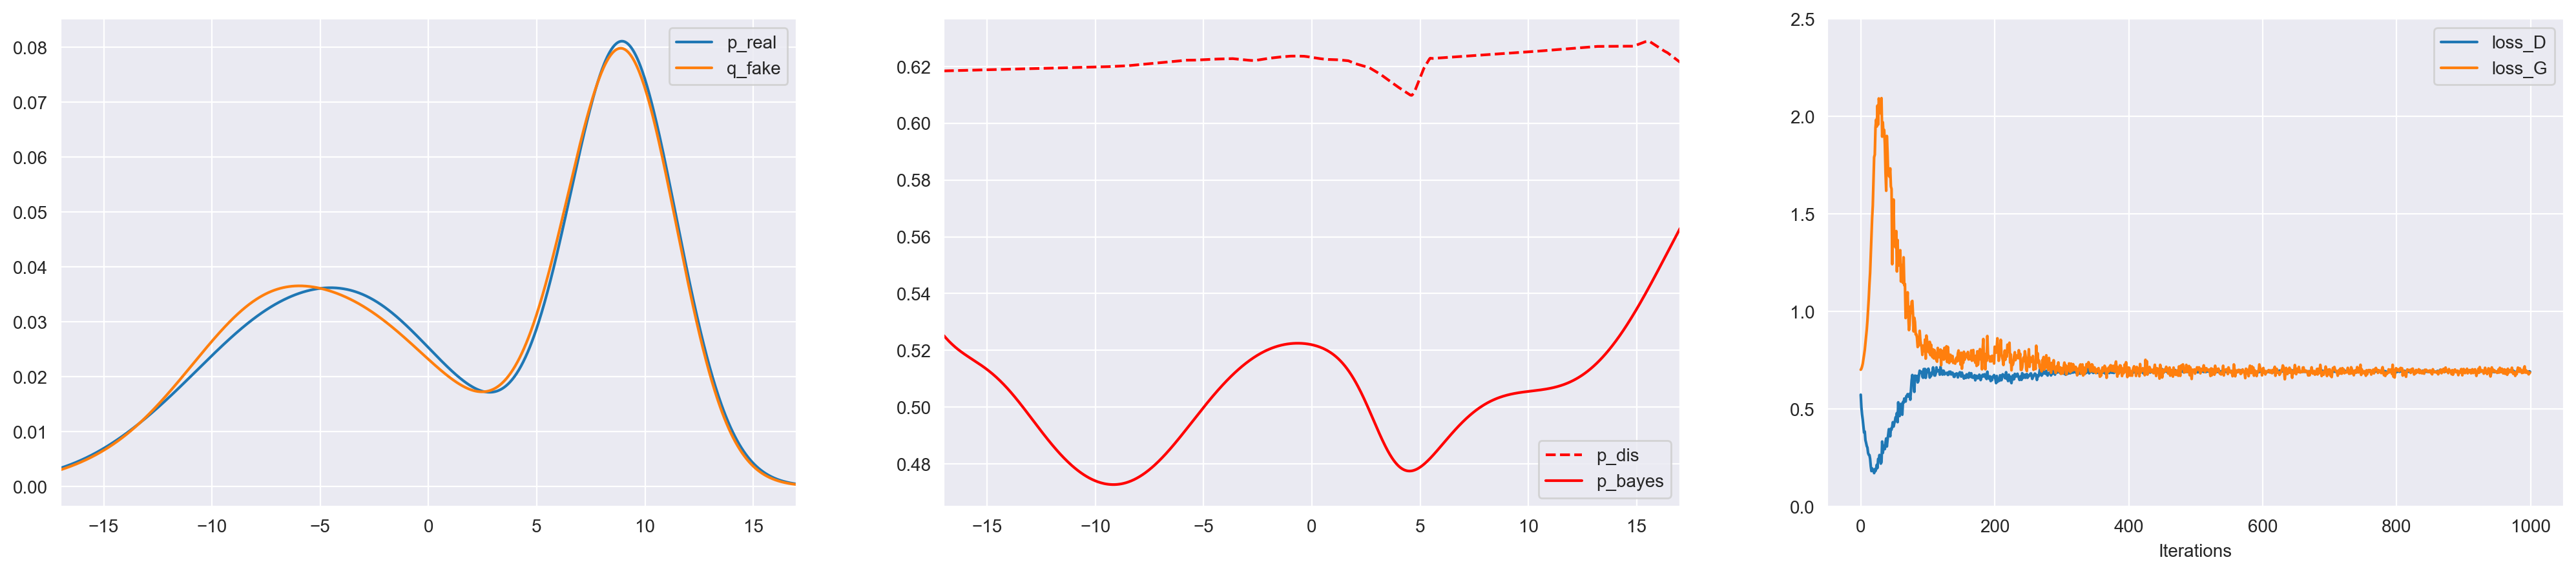

'n_iter: 1000, loss_D: 0.693, loss_G: 0.693'

In [23]:
train_1d_gan(dis, gen, dis_opt, gen_opt, loss = calc_loss, n_iters=1001, n_D_iters = 4, batch_size=128, eval_freq=25)

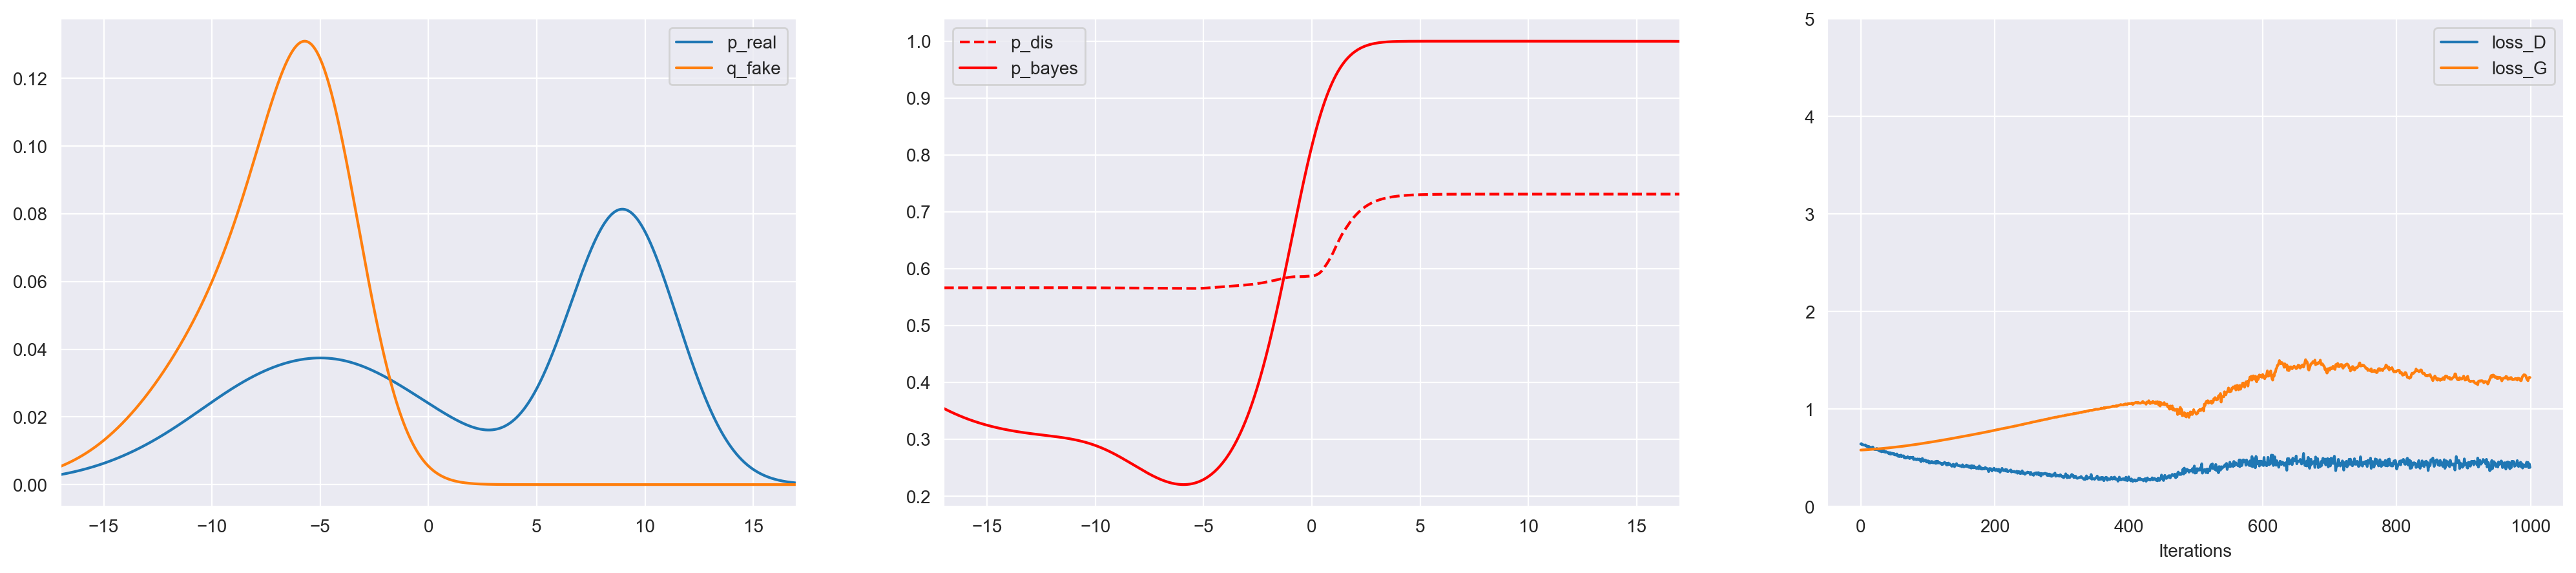

'n_iter: 1000, loss_D: 0.438, loss_G: 1.308'

In [43]:
gen = make_lin_relu_gen().to(DEVICE)
dis = make_lin_relu_dis().to(DEVICE)

gen_opt = torch.optim.SGD(gen.parameters(), lr=1e-2)
dis_opt = torch.optim.SGD(dis.parameters(), lr=1e-2)

train_1d_gan(dis, gen, dis_opt, gen_opt, loss = calc_loss, n_iters=1001, n_D_iters = 1, batch_size=128, eval_freq=100)

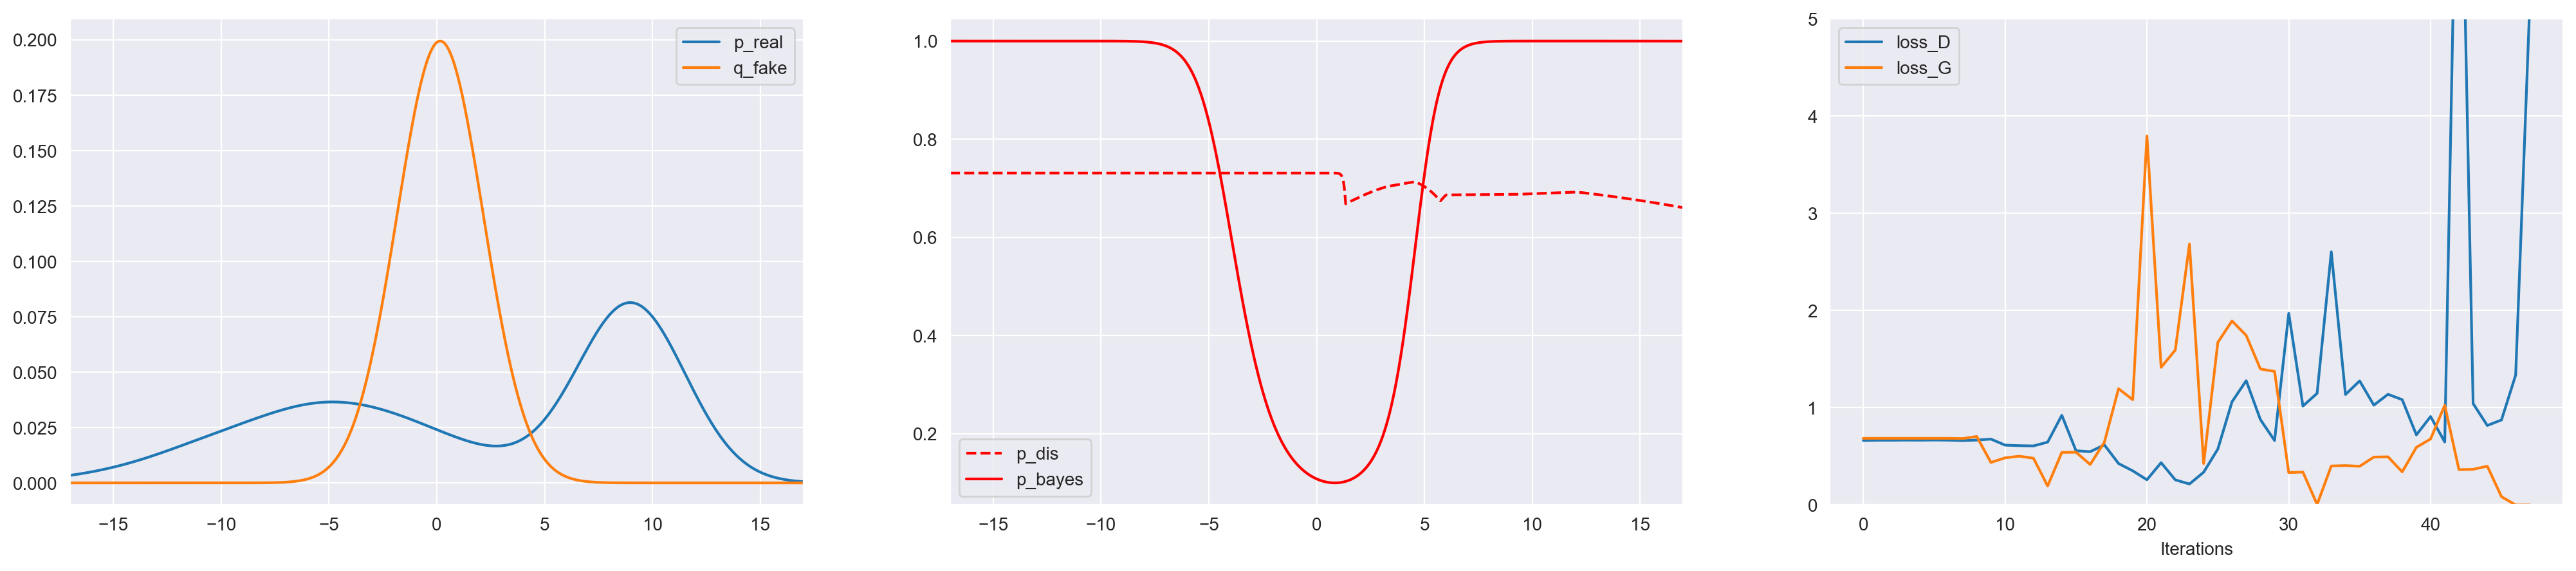

'n_iter: 48, loss_D: 2.462, loss_G: 0.028'

D_loss: inf
G_loss: nan


In [42]:
gen = make_lin_relu_gen().to(DEVICE)
dis = make_lin_relu_dis().to(DEVICE)

gen_opt = QuickPropSGD(gen.parameters(), lr=1e-7)
dis_opt = QuickPropSGD(dis.parameters(), lr=1e-7)

train_1d_gan(dis, gen, dis_opt, gen_opt, loss = calc_loss, n_iters=50, n_D_iters = 1, batch_size=200, print_losses=True, eval_freq=3)